In [1]:
# import nltk; nltk.download('punkt')
# pip install pycocotools
# !python -m pip  install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu118

In [2]:
from dataset import make_dataset, default_image_transform
import os.path as osp

main_path = "/localscratch/kamalida/projects/LEFT/data/clevr/train"
dataset = make_dataset(
    scenes_json=osp.join(main_path, 'scenes.json'),
    questions_json=osp.join(main_path, 'questions.json'),
    image_root=osp.join(main_path, 'images'),
    image_transform=default_image_transform,
    vocab_json=osp.join(main_path, 'vocab.json'),
    output_vocab_json=osp.join(main_path, 'output-vocab.json'),
    incl_scene=True,
    incl_raw_scene=True,
)

Vocab loading: Index 1 for word '0' collides with existing word '<unk>'. Assigning new index for '0'.
Vocab loading: Index 0 for word '<PAD>' collides with existing word '<pad>'. Assigning new index for '<PAD>'.
Vocab loading: Index 1 for word '0' collides with existing word '<unk>'. Assigning new index for '0'.
Vocab loading: Index 0 for word '<PAD>' collides with existing word '<pad>'. Assigning new index for '<PAD>'.


In [3]:
## filter filter_program_size_raw
print(len(dataset)) # 699989
dataset.filter_relational_type()
print("Only conceptual questions are kept")
print(len(dataset)) # 71281

699989
Only conceptual questions are kept
7881


In [4]:
# from pprint import pprint
# pprint(dataset[0]["image"].shape)
# pprint(dataset[0])
# last_programs = set()
# for item in dataset:
#     last_programs.add(item["program"][-1]["function"])
# print(last_programs)

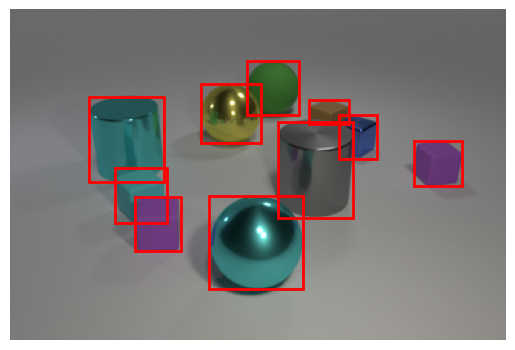

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(dataset[0]["image"])
## for bounding box in dataset[0]["objects_raw"] draw a rectangle
for bbox in dataset[0]["objects"]:
    x_min, y_min, x_max, y_max = bbox
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='red', linewidth=2))
# plt.imshow(np.transpose(dataset[0]["image"], (1, 2, 0)))
plt.axis('off')
plt.show()

In [6]:

from modules import ResNetPatcher
model = ResNetPatcher(resnet_model_name='dummy', pretrained=True, device='cuda')


RuntimeError: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [ ]:
## num parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

308283392


In [ ]:
model(dataset[0]["pil_image"], dataset[0]["objects_raw"])["object_features"][0].shape

torch.Size([2048])

In [ ]:
from dataset import g_attribute_concepts
from pprint import pprint

pprint(g_attribute_concepts)

{'color': ['gray', 'red', 'blue', 'green', 'brown', 'purple', 'cyan', 'yellow'],
 'material': ['rubber', 'metal'],
 'shape': ['cube', 'sphere', 'cylinder'],
 'size': ['small', 'large']}


In [ ]:
from copy import deepcopy 
from tqdm import tqdm
import json
def generate_new_question_file(original_question_file_address, keys_to_remove):
    with open(original_question_file_address, 'r') as f:
        data = json.load(f)
    new_data = deepcopy(data)

    new_data["questions"] = []
    for item in tqdm(data["questions"]):
        functions = " ".join(list(map(lambda x:x["function"], item["program"])))
        valid = True    
        for k in keys_to_remove:
            if k in functions:
                valid = False
                break
        if valid:
            new_data["questions"].append(item)
    with open(original_question_file_address.replace('.json', '_filtered.json'), 'w') as f:
        json.dump(new_data, f, indent=4)

keys_to_remove = ["query", "same_", "relate", "than", "count"]
original_question_file_address = "/localscratch/kamalida/projects/LEFT/data/clevr/train/questions.json"
generate_new_question_file(original_question_file_address, keys_to_remove)